In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import gc
import os
import ast 
import sys
import configparser
import glob
import librosa
import librosa.display
from scipy.stats import mode
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
'''
将声音数字化为频谱数据，我们无需了解音乐频谱原理，我们只需要将其看待成由多个单词组合而成的文本
即可
'''
def load_songs(song_folder):
  song_specs = []
  idx_to_genre = []
  genre_to_idx = {}
  genres = []
  
  for genre in os.listdir(song_folder):
    #为每一种音乐类别进行编号,例如blue对应0,classical对应1
    genre_to_idx[genre] = len(genre_to_idx)
    #将编号对应音乐类别
    idx_to_genre.append(genre)
    genre_folder = os.path.join(song_folder, genre)
    for song in os.listdir(genre_folder):
      #依次进入每个音乐类别文件夹，将音频文件转换为数字频谱序列
      if song.endswith('au'):
        signal, sr = librosa.load(os.path.join(genre_folder, song))
        #获取音乐对应的频谱序列
        melspec = librosa.feature.melspectrogram(signal, sr = sr).T[:1280,]
        song_specs.append(melspec)
        genres.append(genre_to_idx[genre])
  
  '''
  song_specs和genres是两个对应队列，song_specs[i]给出第i首音乐的频谱,
  genre[i]给出该频谱对应的音乐类别
  '''
  return  song_specs, genres, genre_to_idx, idx_to_genre
  
genres_path = '/content/gdrive/My Drive/musics/genres'
song_specs, genres, genre_to_idx, idx_to_genre = load_songs(genres_path)
print(song_specs[0].shape)


(1280, 128)


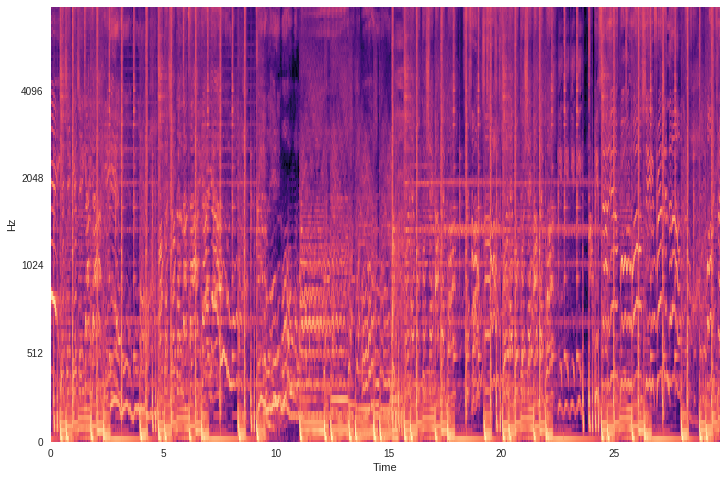

In [51]:
#将频谱绘制成图像
librosa.display.specshow(librosa.power_to_db(song_specs[0].T, ref=np.max),
                        y_axis = 'mel', fmax = 8000, x_axis = 'time')

In [0]:
'''
将频谱数据转换到[0,1]之间，看看频谱数据的分布规律
'''
def  show_spectogram(show_genre):
  show_genre = genre_to_idx[show_genre]
  specs = []
  for spec, genre in zip(song_specs, genres):
    if show_genre == genre:
      specs.append(spec)
      if len(specs) == 25:
        break
        
  if not specs:
    return "not found!"
  x = np.concatenate(specs, axis = 1)
  x = (x - x.min()) / (x.max() - x.min())
  plt.imshow((x*20).clip(0, 1.0))
  

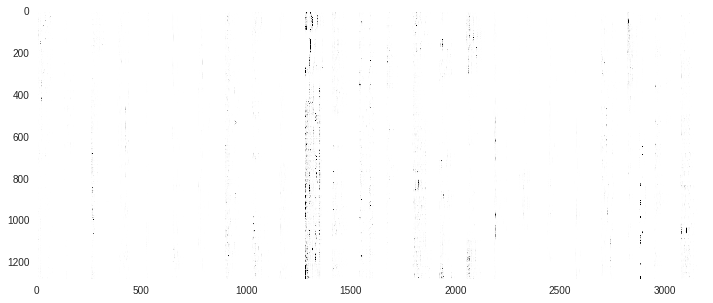

In [53]:
show_spectogram('classical')

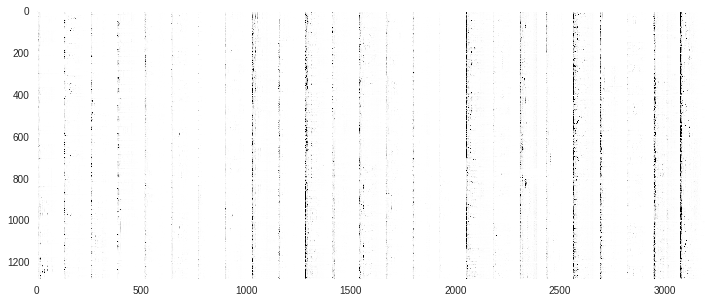

In [54]:
show_spectogram('metal')

In [0]:
import pickle

save_path = '/content/gdrive/My Drive/musics'
pickle.dump(song_specs, open(os.path.join(save_path, "song_specs"), "wb"))
pickle.dump(genres, open(os.path.join(save_path, "genre"), "wb"))
pickle.dump(genre_to_idx, open(os.path.join(save_path, "genre_to_index"), "wb"))
pickle.dump(idx_to_genre, open(os.path.join(save_path, "idx_to_genre"), "wb"))

In [21]:
print(len(song_specs))

1000


In [17]:
import keras

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.merge import concatenate

from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

def  create_model(input_shape):
  inputs = Input(input_shape)
  x = inputs
  levels = 64
  for leven in range(3):
    '''
    构造3个卷积层，第一层卷积层输出向量长度为64，第二层为128，第三层为256
    '''
    #将一维数据分割成没3个元素为一组
    x = Conv1D(levels, 3, activation = 'relu')(x)
    x = BatchNormalization()(x)
    #选取相邻两个数值中最大的那个
    x = MaxPooling1D(pool_size = 2, strides = 2)(x)
    levels *= 2
  
  #分别选取每个向量中的最大值组成一个新向量
  x = GlobalMaxPooling1D()(x)
  #最后连接两个全连接层
  for fc in range(2):
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    
  #将输出划分到10个分类
  labels = Dense(10, activation = 'softmax')(x)
  model = Model(inputs=[inputs], outputs=[labels])
  sgd = keras.optimizers.SGD(lr = 0.0003, momentum = 0.9, decay = 1e-5,
                            nesterov = True)
  model.compile(loss = 'categorical_crossentropy',
               optimizer = sgd,
               metrics = ['accuracy'])
  return model

model = create_model((128, 128))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 126, 64)           24640     
_________________________________________________________________
batch_normalization_7 (Batch (None, 126, 64)           256       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 61, 128)           24704     
_________________________________________________________________
batch_normalization_8 (Batch (None, 61, 128)           512       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 30, 128)           0         
__________

In [0]:
import pickle

save_path = '/content/gdrive/My Drive/musics'
song_specs = pickle.load(open(os.path.join(save_path, "song_specs"), "rb"))
genres = pickle.load(open(os.path.join(save_path, "genre"), "rb"))
genre_to_idx = pickle.load(open(os.path.join(save_path, "genre_to_index"), "rb"))
idx_to_genre = pickle.load(open(os.path.join(save_path, "idx_to_genre"), "rb"))

In [16]:
from sklearn.model_selection import train_test_split

'''
将每首10秒的曲子分成10段每首3秒的曲子
'''
def  split_10(x, y):
  #x是频谱数据,y是对应分类
  s = x.shape
  #切分成10段
  s = (s[0] * 10, s[1] // 10, s[2])
  #切分的10段新数据依然对应同一个分类
  return x.reshape(s), np.repeat(y, 10, axis = 0)

#将分类对应的数值转换成one-hot-vector
genres_one_hot = keras.utils.to_categorical(genres, num_classes = len(genre_to_idx))

#将数据分割成训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(np.array(song_specs),
                                                   np.array(genres_one_hot),
                                                   test_size = 0.1,
                                                   stratify = genres)
x_test, y_test = split_10(x_test, y_test)
x_train, y_train = split_10(x_train, y_train)

print(x_train.shape, y_train.shape)

(9000, 128, 128) (9000, 10)


In [18]:
#当连续进行三次循环训练后网络对校验数据的识别正确率没有提升，那么终止训练流程
earlystop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         min_delta = 0,
                                         patience = 3,
                                         verbose = 0,
                                         mode = 'auto')
history = model.fit(x_train, y_train, batch_size = 128,
                   epochs = 100, verbose = 1,
                   validation_data = (x_test, y_test),
                   callbacks = [earlystop])

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 4s 454us/step - loss: 3.5296 - acc: 0.1360 - val_loss: 2.1623 - val_acc: 0.2320
Epoch 2/100
9000/9000 [==============================] - 3s 310us/step - loss: 2.4193 - acc: 0.1962 - val_loss: 2.0279 - val_acc: 0.2880
Epoch 3/100
9000/9000 [==============================] - 3s 310us/step - loss: 2.1884 - acc: 0.2320 - val_loss: 1.9812 - val_acc: 0.3090
Epoch 4/100
9000/9000 [==============================] - 3s 311us/step - loss: 2.0934 - acc: 0.2630 - val_loss: 1.9338 - val_acc: 0.3140
Epoch 5/100
9000/9000 [==============================] - 3s 308us/step - loss: 2.0453 - acc: 0.2687 - val_loss: 1.9069 - val_acc: 0.3360
Epoch 6/100
9000/9000 [==============================] - 3s 312us/step - loss: 1.9944 - acc: 0.2878 - val_loss: 1.8751 - val_acc: 0.3470
Epoch 7/100
9000/9000 [==============================] - 3s 313us/step - loss: 1.9494 - acc: 0.2978 - val_loss: 1.8433 - val_acc: 

In [0]:
save_path = '/content/gdrive/My Drive/musics/song_classify.h5'
model.save(save_path)

In [19]:
from sklearn.metrics import accuracy_score

def  unsplit(values):
  #把10个数组合成一个大数组
  chunks = np.split(values, 100)
  #返回大数组中最大值得下标后求余，得到该首歌曲所属分类
  return np.array([np.argmax(chunk) % 10 for chunk in chunks])



pred_values = model.predict(x_test)

predictions = unsplit(pred_values)

truth = unsplit(y_test)

accuracy_score(predictions, truth)

0.62

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(pred_values, axis = 1), 
                      np.argmax(y_test, axis = 1))
print(cm)

[[64  1  2  0 10 33  0  5  0 10]
 [ 2 67  2  0  2  1  3  0  0  0]
 [ 2  1 42  5  0  2 21  1  4 19]
 [ 7 10  2 87  0  0  0  0 40  1]
 [ 3  9  0  0 79  4  3  6  0  9]
 [16 10  1  0  1 49  0  0  1  0]
 [ 1  1 13  0  2  3 49  7  3 18]
 [ 2  0  9  4  6  2 11 70  5 20]
 [ 3  1 12  1  0  2  9  0 47  6]
 [ 0  0 17  3  0  4  4 11  0 17]]


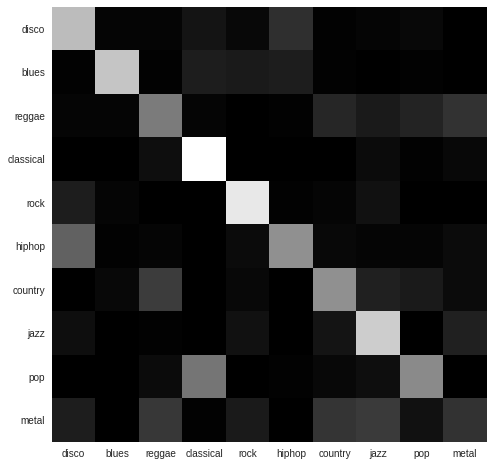

In [22]:
plt.imshow(cm.T, interpolation = 'nearest', cmap = 'gray')
plt.grid(False)
plt.xticks(np.arange(0, len(idx_to_genre)), idx_to_genre)
plt.yticks(np.arange(0, len(idx_to_genre)), idx_to_genre)

plt.show()